In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import glob

In [24]:
nx = 9
ny = 6
imagepts=[]
objectpts=[]
object_points = []
image_points = []
object_points = np.zeros((9*6,3), np.float32)
object_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [25]:
images = glob.glob("./camera_cal/calibration*.jpg")

In [26]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, image_points = cv2.findChessboardCorners(gray, (9,6), None)
    if(ret):
        imagepts.append(image_points)
        objectpts.append(object_points)
    

In [27]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpts, imagepts, gray.shape[::-1], None, None)

print(mtx,dist)
print(type(mtx),type(dist))

[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


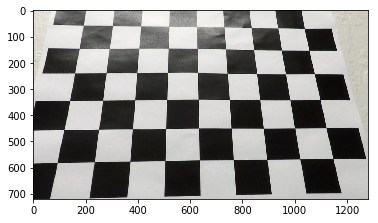

In [28]:
img = mimg.imread("./camera_cal/calibration3.jpg")

undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [29]:
#mimg.imsave('./output_images/calibration3_unDistor.jpg',undist)

In [30]:
images = glob.glob("./test_images/*.jpg")

for fname in images:
    img = mimg.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = cv2.cvtColor(undist,cv2.COLOR_BGR2RGB)
    print(undist.shape)
    mimg.imsave("./test_images_undist/"+"undist_"+fname.split('/')[2],undist)
    #print((cv2.imread("./test_images_undist/undist_test1.jpg")).shape)
    #plt.imshow(cv2.imread("./test_images_undist/undist_test1.jpg"),cmap='viridis')

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


In [31]:
def sobel_abs_thresh(img,thresh, orient='x', sobel_kernel=3):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel=hls[:,:,2]
    sobel = cv2.Sobel(s_channel, cv2.CV_64F, 1&(orient=='x'), 1&(orient=='y'),ksize =sobel_kernel)   
    abs_sobel = np.absolute(sobel)   
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    bin_sobel = np.zeros_like(scaled_sobel)
    bin_sobel[(scaled_sobel > thresh[0])&(scaled_sobel < thresh[1])] = 1   
    return bin_sobel
    
def mag_thresh(img,mag_thresh, sobel_kernel=3):     
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel=hls[:,:,2]
    sobelx = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 1, 0,ksize =sobel_kernel))
    sobely = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 0, 1,ksize =sobel_kernel))    
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel =np.uint8(255*sobel/np.max(sobel))
    binary_output = np.zeros_like(sobel)
    binary_output[((sobel >= mag_thresh[0]) & (sobel <= mag_thresh[1]))] = 1
    return binary_output
    

def dir_thresh(img,thresh, sobel_kernel=3):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel=hls[:,:,2]
    sobelx = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 1, 0,ksize =sobel_kernel))
    sobely = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 0, 1,ksize =sobel_kernel))
    dir  =np.arctan2(sobely, sobelx)   
    bin_img =np.zeros_like(sobelx)
    bin_img[(dir >= thresh[0]) & (dir<=thresh[1])] = 1    
    return bin_img

def combine_thresh(image,threshx=(0,255),threshy=(0,255),threshMag= (0,255),threshDir=(0.7,1.3),ksize=3):
    gradx = sobel_abs_thresh(image,threshx, orient='x', sobel_kernel=ksize)
    grady = sobel_abs_thresh(image,threshy, orient='y', sobel_kernel=ksize)
    mag_binary = mag_thresh(image,threshMag, sobel_kernel=ksize)
    dir_binary = dir_thresh(image, threshDir,sobel_kernel=ksize)
    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(24, 9))
    ax1.imshow(gradx,cmap='gray')
    ax2.imshow(grady,cmap='gray')
    ax3.imshow(mag_binary,cmap='gray')
    ax4.imshow(dir_binary,cmap='gray')
    combined = np.zeros_like(dir_binary)
    combined[(gradx==1) |(mag_binary==1) & (dir_binary==1)] = 1
    #ax2.imshow(combined,cmap='gray')
    return combined
    

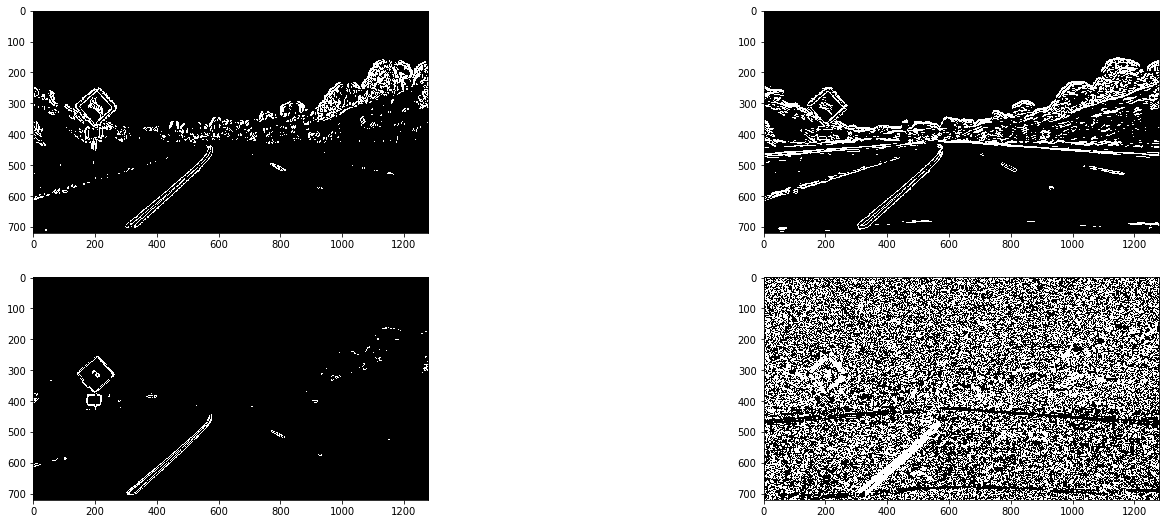

In [32]:
image = mimg.imread('./test_images_undist/undist_test2.jpg')
ksize = 17
bin_img = combine_thresh(image,threshx = (20,100),threshy=(20,100),threshMag= (100,200),threshDir=(0.5,1.3,),ksize=17)



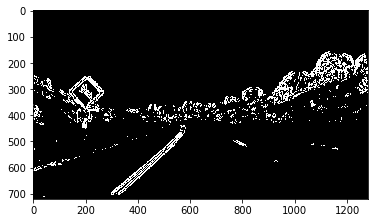

In [33]:
plt.imshow(bin_img,'gray')


In [34]:
#mimg.imsave('./output_images/undist_straight_lines1_thresh_binary.jpg',combined,cmap = 'gray')

(720, 1280, 4)


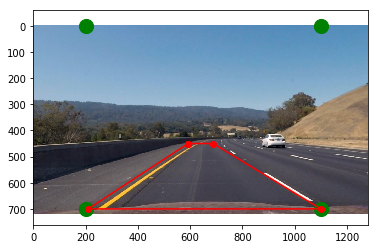

In [35]:
image = mimg.imread('./test_images_undist/undist_test3.jpg')  
img_size = (image.shape[1],image.shape[0])
#src = np.float32([[580,450],[700,450],[960,620],[330,620]])
src = np.float32([[592,450],[688,450],[1100,700],[210,700]])
plt.imshow(image) 
print(image.shape)
#plt.scatter(src[:,0],src[:,1],marker = 'x',color = "red",s =200)
plt.plot(np.append(src[:,0],src[0,0]),np.append(src[:,1],src[0,1]),'ro-')
#offset = 400
#dst=np.float32([[offset, offset], [img_size[0]-offset, offset],[img_size[0]-offset, img_size[1]-offset],[offset, img_size[1]-offset]])
dst = np.float32([[200,0],[1100,0],[1100,700],[200,700]])
plt.scatter(dst[:,0],dst[:,1],marker = 'o',color = "green",s =200)
M= cv2.getPerspectiveTransform(src,dst)
warped = cv2.warpPerspective(image, M, img_size)


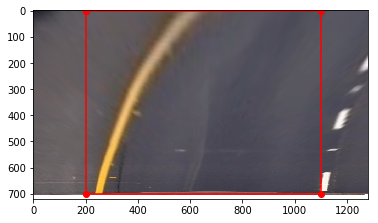

In [36]:
plt.imshow(warped) 
plt.plot(np.append(dst[:,0],dst[0,0]),np.append(dst[:,1],dst[0,1]),'ro-')

In [37]:

images = glob.glob("./test_images_undist/*.jpg")
for fname in images:
    image = mimg.imread(fname)  
    img_size = (image.shape[1],image.shape[0])
    src = np.float32([[592,450],[688,450],[1100,700],[210,700]])
    #plt.imshow(image) 
    #plt.scatter(src[:,0],src[:,1],marker = 'x',color = "red",s =200)
    #offset = 400
    #dst=np.float32([[offset, offset], [img_size[0]-offset, offset],[img_size[0]-offset, img_size[1]-offset],[offset, img_size[1]-offset]])
    dst = np.float32([[200,0],[1100,0],[1100,700],[200,700]])
    #plt.scatter(dst[:,0],dst[:,1],marker = 'o',color = "green",s =200)
    M= cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(image, M, img_size)
    #mimg.imsave("./output_images/"+"BirdView_"+fname.split('/')[2],warped)

(720, 1280, 4)


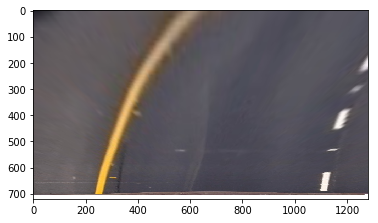

In [38]:
image = mimg.imread("./output_images/BirdView_undist_test3.jpg")  
print(image.shape)
plt.imshow(image)

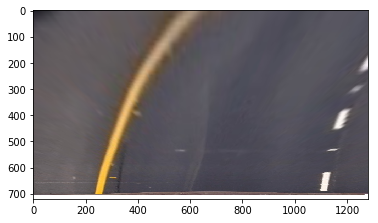

In [39]:
plt.imshow(image)

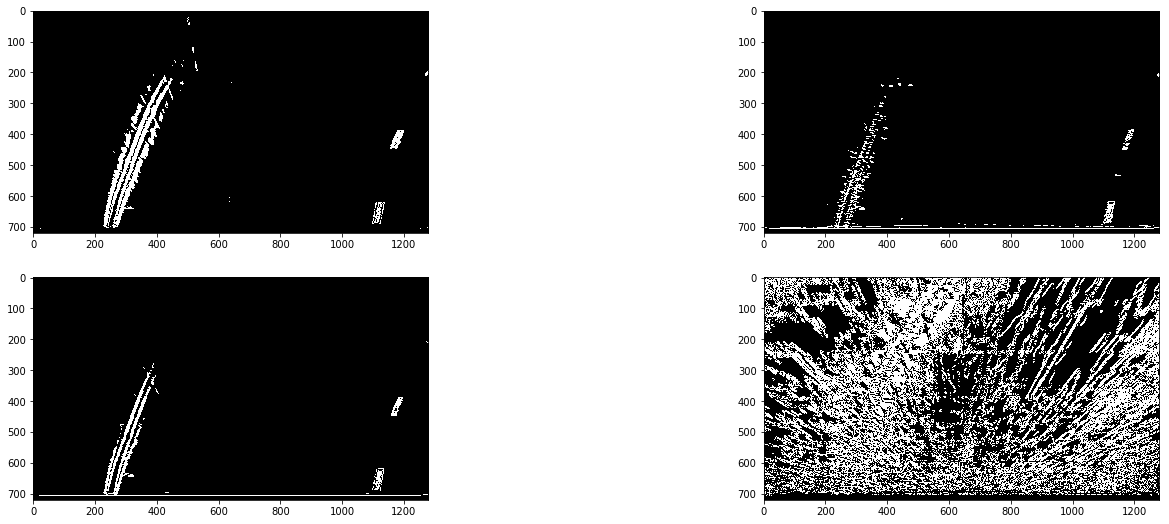

In [40]:
binary_warped = combine_thresh(image,threshx = (10,100),threshy=(10,100),threshMag= (20,100),threshDir=(0.3,1.3,),ksize=5)

(array([ 19,  20,  21, ..., 706, 706, 706]), array([ 501,  501,  501, ...,   25, 1243, 1244]))


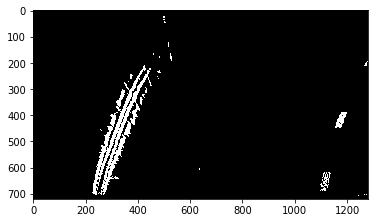

In [41]:
plt.imshow(binary_warped,cmap = 'gray')
print(binary_warped.nonzero())

In [20]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis =0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img = out_img.astype(np.uint8)
    #print("o",out_img)
    midpoint = histogram.shape[0]//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    margin = 100
    minpix =50
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height        
        win_xleft_low = leftx_current-margin  
        win_xleft_high = leftx_current+margin 
        win_xright_low = rightx_current-margin 
        win_xright_high = rightx_current+margin   
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)    
        
        good_left_inds = np.where((nonzerox>=win_xleft_low)&(nonzerox<=win_xleft_high)& (nonzeroy >=win_y_low )&(nonzeroy <= win_y_high))[0]
        good_right_inds = np.where((nonzerox>=win_xright_low)&(nonzerox<=win_xright_high)&(nonzeroy >=win_y_low )&(nonzeroy <= win_y_high))[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)        
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))   
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)    
    leftx = nonzerox[left_lane_inds]    
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    return leftx, lefty, rightx, righty, out_img
   


In [21]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fit,right_fit,left_fitx,right_fitx,out_img,ploty




In [22]:
def mark_road(binary_warped):
    left_fit,right_fit,left_fitx,right_fitx,out_img,ploty = fit_polynomial(binary_warped)
    window_img = np.zeros_like(out_img)
    line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    line_pts = np.hstack((line_window1, line_window2))
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    
    lane_sep=right_fitx[np.int_(np.max(ploty))]-left_fitx[np.int_(np.max(ploty))]
    lane_cent = left_fitx[np.int_(np.max(ploty))]+(lane_sep)/2
    veh_cent = out_img.shape[1]/2
    mx=3.7/700 
    my=30/720
    scaled_y_eval = np.max(ploty)*my
    scaled_lf0 = (left_fit[0]*mx) / (my ** 2) 
    scaled_lf1 = left_fit[1]*mx/my
    left_curverad = ((1+(2*scaled_lf0*scaled_y_eval+scaled_lf1)**2)**(3/2))/(2*np.absolute(scaled_lf0))
    return window_img,left_curverad,(veh_cent-lane_cent)*mx
    


curvature 547.054645051 Deviation -0.526288779133


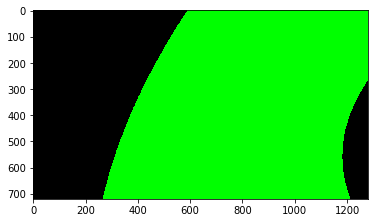

In [28]:
out,curvature,deviation = mark_road(binary_warped)

plt.imshow(out)
print("curvature",curvature,"Deviation",deviation)
#mimg.imsave("./output_images/fit_poly_test6.jpg",out)

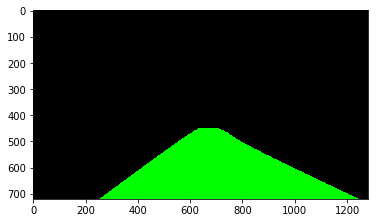

In [24]:
img_size = (out.shape[1],out.shape[0])
#src = np.float32([[580,450],[700,450],[960,620],[330,620]])
src = np.float32([[200,0],[1100,0],[1100,700],[200,700]])

#plt.scatter(src[:,0],src[:,1],marker = 'x',color = "red",s =200)

#offset = 400
#dst=np.float32([[offset, offset], [img_size[0]-offset, offset],[img_size[0]-offset, img_size[1]-offset],[offset, img_size[1]-offset]])

dst = np.float32([[592,450],[688,450],[1100,700],[210,700]])

M= cv2.getPerspectiveTransform(src,dst)
warped = cv2.warpPerspective(out, M, img_size)
plt.imshow(warped) 

In [25]:
image = mimg.imread('./test_images_undist/undist_test6.jpg') 
print(warped.shape)
print(image.shape)
result = cv2.addWeighted(image[:,:,:3], 1, warped, 0.3, 0)
font = cv2.FONT_HERSHEY_SIMPLEX 
  
  
# fontScale 
fontScale = 1.5
   
# Blue color in BGR 
color = (255, 255, 255) 
  
# Line thickness of 2 px 
thickness = 2
   
# Using cv2.putText() method 
result = cv2.putText(result, "Radius of Curvature = "+str(int(curvature))+"(m)", (300, 100), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
deviation = float(format(deviation,'.2f'))
if(deviation < 0):
    text  ="Vehicle is "+str(np.absolute(deviation))+"m left of center"
elif(deviation >0):
    text  ="Vehicle is "+str(deviation)+"m right of center"
else:
    text  ="Vehicle is on center line"
result = cv2.putText(result, text, (300,150), font,  
                   fontScale, color, thickness, cv2.LINE_AA)


(720, 1280, 3)
(720, 1280, 4)


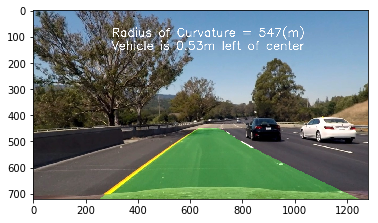

In [29]:
plt.imshow(result)
mimg.imsave("./output_images/lane_curve_dev_test6.jpg",result)

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import glob

In [2]:
class lane:
    def __init__(self):
        self.fit =np.array([],np.float16)
        self.fitx = np.array([],np.int16)
        self.curvature = 0
        self.fit_diff = np.array([],np.float16)
        self.slope = 0.0
        self.fitx_avg=np.array([],np.int16)

    
    
        
    
    

    
    
    

In [3]:

class frame:
    def __init__(self,image):
        self.undist_image=cv2.undistort(image, frame.mtx, frame.dist, None, frame.mtx)
        self.img_size = (self.undist_image.shape[1],self.undist_image.shape[0])
        self.bird_view=np.array([])
        self.binary_bird_view=np.array([])
        self.nonzero=np.array([])
        self.nonzerox=np.array([])
        self.nonzeroy=np.array([])
        self.leftx=np.array([])
        self.lefty=np.array([])
        self.rightx=np.array([])
        self.righty=np.array([])
        self.out_img=np.array([])
        self.vehicle_deviation = 0.0
        self.left_lane=lane()
        self.right_lane=lane()
        self.ploty = np.array([])
        self.window_img = np.array([])
        self.car_lane_view=np.array([])
        self.output_frame=np.array([])
        self.lane_sep = 0.0
    left_fitx_buffer = []
    right_fitx_buffer =[]


    mtx = np.array([[  1.15777818e+03,0.00000000e+00,6.67113857e+02],[ 0.00000000e+00 ,1.15282217e+03,3.86124583e+02], [ 0.00000000e+00,0.00000000e+00,1.00000000e+00]])
    dist=np.array([[-0.24688507,-0.02373155,-0.00109831,0.00035107,-0.00259868]])
    kernel=17
    mx=3.7/700 
    my=30/720
    left_lane_points_fit =np.array([])
    right_lane_points_fit = np.array([])
    sane = False
    insane = 0



    def create_bird_view(self):
        img_size = (self.undist_image.shape[1],self.undist_image.shape[0])
        src = np.float32([[592,450],[688,450],[1100,700],[210,700]])
        dst = np.float32([[200,0],[1100,0],[1100,700],[200,700]])
        M= cv2.getPerspectiveTransform(src,dst)
        self.bird_view = cv2.warpPerspective(self.undist_image, M, img_size)


    def sobel_abs_thresh(self,thresh, orient='x'):
        hls = cv2.cvtColor(self.bird_view, cv2.COLOR_RGB2HLS)
        s_channel=hls[:,:,2]
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 1&(orient=='x'), 1&(orient=='y'),ksize=frame.kernel)   
        abs_sobel = np.absolute(sobel)   
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        bin_sobel = np.zeros_like(scaled_sobel)
        bin_sobel[(scaled_sobel > thresh[0])&(scaled_sobel < thresh[1])] = 1   
        return bin_sobel

    def mag_thresh(self,mag_thresh):     
        hls = cv2.cvtColor(self.bird_view, cv2.COLOR_RGB2HLS)
        s_channel=hls[:,:,2]
        sobelx = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 1, 0,ksize =frame.kernel))
        sobely = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 0, 1,ksize =frame.kernel))    
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel =np.uint8(255*sobel/np.max(sobel))
        binary_output = np.zeros_like(sobel)
        binary_output[((sobel >= mag_thresh[0]) & (sobel <= mag_thresh[1]))] = 1
        return binary_output


    def dir_thresh(self,thresh):
        #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(self.bird_view, cv2.COLOR_RGB2HLS)
        s_channel=hls[:,:,2]
        sobelx = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 1, 0,ksize =frame.kernel))
        sobely = np.absolute(cv2.Sobel(s_channel, cv2.CV_64F, 0, 1,ksize =frame.kernel))
        dir  =np.arctan2(sobely, sobelx)   
        bin_img =np.zeros_like(sobelx)
        bin_img[(dir >= thresh[0]) & (dir<=thresh[1])] = 1    
        return bin_img

    def create_th_binary(self,threshx=(0,255),threshy=(0,255),threshMag= (0,255),threshDir=(0.7,1.3)):
        gradx = self.sobel_abs_thresh(threshx, orient='x')
        grady = self.sobel_abs_thresh(threshy, orient='y')
        mag_binary = self.mag_thresh(threshMag)
        dir_binary = self.dir_thresh(threshDir)
        self.binary_bird_view = np.zeros_like(dir_binary)
        self.binary_bird_view[(gradx==1) |(mag_binary==1) & (dir_binary==1)] = 1    
        self.ploty = np.linspace(0, self.binary_bird_view.shape[0]-1, self.binary_bird_view.shape[0] )
        self.out_img = np.dstack((self.binary_bird_view, self.binary_bird_view, self.binary_bird_view))
        self.out_img = self.out_img.astype(np.uint8)


    def extract_lane_points(self):
        if(frame.sane == True):
            margin = 100    
            nonzero = self.binary_bird_view.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1]) 
            left_lane_inds = (nonzerox>(frame.left_lane_points_fit[0]*nonzeroy**2+frame.left_lane_points_fit[1]*nonzeroy+frame.left_lane_points_fit[2] - margin)) &(nonzerox<(frame.left_lane_points_fit[0]*nonzeroy**2+frame.left_lane_points_fit[1]*nonzeroy+frame.left_lane_points_fit[2] + margin))
            right_lane_inds = (nonzerox>(frame.right_lane_points_fit[0]*nonzeroy**2+frame.right_lane_points_fit[1]*nonzeroy+frame.right_lane_points_fit[2] - margin)) &(nonzerox<(frame.right_lane_points_fit[0]*nonzeroy**2+frame.right_lane_points_fit[1]*nonzeroy+frame.right_lane_points_fit[2] + margin))
            self.leftx = nonzerox[left_lane_inds]    
            self.lefty = nonzeroy[left_lane_inds] 
            self.rightx = nonzerox[right_lane_inds]
            self.righty = nonzeroy[right_lane_inds]

        else:
            histogram = np.sum(self.binary_bird_view[self.binary_bird_view.shape[0]//2:,:],axis =0)
            
            midpoint = histogram.shape[0]//2
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:])+midpoint
            margin = 100
            minpix =50
            nwindows = 9
            window_height = np.int(self.binary_bird_view.shape[0]//nwindows)
            nonzero = self.binary_bird_view.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            leftx_current = leftx_base
            rightx_current = rightx_base
            left_lane_inds = []
            right_lane_inds = []
            for window in range(nwindows):
                win_y_low = self.binary_bird_view.shape[0] - (window+1)*window_height
                win_y_high = self.binary_bird_view.shape[0] - window*window_height        
                win_xleft_low = leftx_current-margin  
                win_xleft_high = leftx_current+margin 
                win_xright_low = rightx_current-margin 
                win_xright_high = rightx_current+margin           
                good_left_inds = np.where((nonzerox>=win_xleft_low)&(nonzerox<=win_xleft_high)& (nonzeroy >=win_y_low )&(nonzeroy <= win_y_high))[0]
                good_right_inds = np.where((nonzerox>=win_xright_low)&(nonzerox<=win_xright_high)&(nonzeroy >=win_y_low )&(nonzeroy <= win_y_high))[0]
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)        
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))   

            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)    
            self.leftx = nonzerox[left_lane_inds]    
            self.lefty = nonzeroy[left_lane_inds] 
            self.rightx = nonzerox[right_lane_inds]
            self.righty = nonzeroy[right_lane_inds]
            self.out_img[self.lefty,self.leftx]=[255,0,0]
            frame.insane = 0



    def fit_polynomial(self):

        if(len(self.lefty)  >0 and len(self.leftx)>0 and len(self.righty)  >0 and len(self.rightx)>0):
            self.left_lane.fit = np.polyfit(self.lefty, self.leftx, 2)
            self.right_lane.fit = np.polyfit(self.righty, self.rightx, 2)

            if(len(self.left_lane.fit)>0 and len(self.right_lane.fit)>0):

                frame.left_lane_points_fit = self.left_lane.fit
                frame.right_lane_points_fit = self.right_lane.fit
                '''
                print("from fit")
                print(frame.left_lane_points_fit)
                print(frame.right_lane_points_fit)
                print("end fit")
                '''


            try:
                self.left_lane.fitx = self.left_lane.fit[0]*self.ploty**2 + self.left_lane.fit[1]*self.ploty + self.left_lane.fit[2]
                self.right_lane.fitx = self.right_lane.fit[0]*self.ploty**2 + self.right_lane.fit[1]*self.ploty + self.right_lane.fit[2]
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                self.left_lane.fitx = 1*self.ploty**2 + 1*self.ploty 
                self.right_lane.fitx = 1*self.ploty**2 + 1*self.ploty 


            frame.left_fitx_buffer.append(self.left_lane.fitx)
            frame.right_fitx_buffer.append(self.right_lane.fitx)

            if(len(frame.left_fitx_buffer) > 10):       
                frame.left_fitx_buffer.pop(0)   
                frame.right_fitx_buffer.pop(0) 


        self.left_lane.fitx_avg = np.mean(np.transpose(frame.left_fitx_buffer),axis=1,dtype = np.uint16)
        self.right_lane.fitx_avg =np.mean(np.transpose(frame.right_fitx_buffer),axis=1,dtype = np.uint16)
        #print(self.left_lane.fitx_avg)
        #print(self.right_lane.fitx_avg)


    def mark_road(self):

        line_window1 = np.array([np.transpose(np.vstack([self.left_lane.fitx_avg, self.ploty]))])
        line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_lane.fitx_avg,self.ploty])))])
        line_pts = np.hstack((line_window1, line_window2))
        self.window_img = np.zeros_like(self.out_img)
        cv2.fillPoly(self.window_img, np.int_([line_pts]), (0,255, 0))
        #plt.imshow(self.window_img)

    def calc_lane_properties(self):
        self.lane_sep=self.right_lane.fitx_avg[np.int_(np.max(self.ploty))]-self.left_lane.fitx_avg[np.int_(np.max(self.ploty))]
        lane_cent = self.left_lane.fitx_avg[np.int_(np.max(self.ploty))]+(self.lane_sep)/2
        veh_cent = self.img_size[0]/2
        scaled_y_eval = np.max(self.ploty)*frame.my
        '''
        print("calc_prop")
        print(frame.right_lane_points_fit)
        if (len(frame.right_lane_points_fit)==0):
            print("spotted")
        '''
        scaled_rf0 = frame.right_lane_points_fit[0]*frame.mx /(frame.my ** 2)
        scaled_rf1 = frame.right_lane_points_fit[1]*frame.mx/self.my
        self.right_lane.curvature = ((1+(2*scaled_rf0*scaled_y_eval+scaled_rf1)**2)**(3/2))/(2*np.absolute(scaled_rf0))
        scaled_lf0 = frame.left_lane_points_fit[0]*frame.mx / (frame.my ** 2) 
        scaled_lf1 = frame.left_lane_points_fit[1]*frame.mx/frame.my
        self.left_lane.curvature = ((1+(2*scaled_lf0*scaled_y_eval+scaled_lf1)**2)**(3/2))/(2*np.absolute(scaled_lf0))
        self.vehicle_deviation = (veh_cent-lane_cent)*frame.mx

    def sanity_check(self):
        curvature_diff = self.left_lane.curvature - self.right_lane.curvature
        self.right_lane.slope = (600-400)/(self.right_lane.fitx_avg[600]-self.right_lane.fitx_avg[400])
        self.left_lane.slope = (600-400)/(self.left_lane.fitx_avg[600]-self.left_lane.fitx_avg[400])

        if(((curvature_diff < 4)or(curvature_diff > 20)) or ((self.lane_sep/curvature_diff) >2 or (curvature_diff/self.lane_sep)>2) 
        or (np.absolute(self.right_lane.slope - self.left_lane.slope) >3)):
            frame.insane =frame.insane+1
        else:
            frame.insane = 0
            frame.sane = True
        if(frame.insane>10):
            frame.sane = False




    def create_output_frame(self):
        src = np.float32([[200,0],[1100,0],[1100,700],[200,700]])
        dst = np.float32([[592,450],[688,450],[1100,700],[210,700]])
        M= cv2.getPerspectiveTransform(src,dst)
        self.car_lane_view = cv2.warpPerspective(self.window_img, M, self.img_size)    
        self.output_frame = cv2.addWeighted(self.undist_image[:,:,:3], 1, self.car_lane_view, 0.3, 0)
        #print(self.output_frame.shape)
        font = cv2.FONT_HERSHEY_SIMPLEX
        # fontScale 
        fontScale = 1.5
        # Blue color in BGR 
        color = (255, 255, 255)
        # Line thickness of 2 px 
        thickness = 2
        # Using cv2.putText() method 
        self.output_frame = cv2.putText(self.output_frame, "Radius of Curvature = "+str(int(self.left_lane.curvature))+"(m)", (300, 100), font,  
                           fontScale, color, thickness, cv2.LINE_AA)
        self.vehicle_deviation = float(format(self.vehicle_deviation,'.2f'))
        if(self.vehicle_deviation < 0):
            text  ="Vehicle is "+str(np.absolute(self.vehicle_deviation))+"m left of center"
        elif(self.vehicle_deviation  >0):
            text  ="Vehicle is "+str(self.vehicle_deviation)+"m right of center"
        else:
            text  ="Vehicle is on center line"
        self.output_frame = cv2.putText(self.output_frame, text, (300,150), font,fontScale, color, thickness, cv2.LINE_AA)
        #text = "Sanity - "+str(frame.sane)
        #self.output_frame = cv2.putText(self.output_frame,text , (400,200), font,fontScale, color, thickness, cv2.LINE_AA)



In [4]:
def process_frame(image):
    fr = frame(image)
    fr.create_bird_view()
    fr.create_th_binary(threshx = (20,100),threshy=(20,100),threshMag= (100,200),threshDir=(0.5,1.3,))
    fr.extract_lane_points()
    fr.fit_polynomial()
    fr.calc_lane_properties()
    fr.mark_road()
    fr.sanity_check()
    fr.create_output_frame()
    return fr.output_frame



In [5]:
output_video = './output_video/project_video.mp4'
#clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output_video/project_video.mp4
[MoviePy] Writing video ./output_video/project_video.mp4


100%|█████████▉| 1260/1261 [09:07<00:00,  2.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video.mp4 

CPU times: user 6min 29s, sys: 26.9 s, total: 6min 56s
Wall time: 9min 10s


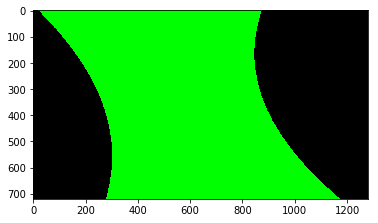

In [52]:
cap = cv2.VideoCapture('./challenge_video.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 350-1)
res, image = cap.read()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fr = frame(image)
fr.create_bird_view()
fr.create_th_binary(threshx = (20,100),threshy=(20,100),threshMag= (100,200),threshDir=(0.5,1.3,))
fr.extract_lane_points()
fr.fit_polynomial()
fr.calc_lane_properties()
fr.mark_road()
fr.sanity_check()
fr.create_output_frame()
#plt.imshow(fr.output_frame)

#plt.imshow(fr.window_img)
plt.imshow(fr.window_img)

#plt.imshow(fr.binary_bird_view)


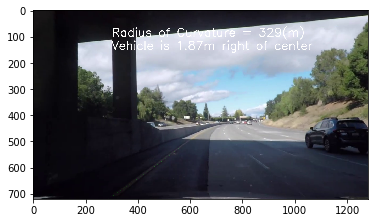

In [32]:
plt.imshow(fr.output_frame)

In [106]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))